In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Caminho do arquivo CSV no Google Drive
csv_file = '/content/drive/My Drive/Dados TB 13-23/dados_tuberculose_2013_2023_limpo.csv'

df = pd.read_csv(csv_file, encoding='latin1', low_memory=False)

In [ ]:
# Filtrar para o estado de São Paulo (SG_UF == 35)
df_sp = df[df['SG_UF'] == 35].copy()

# Confirmar o tamanho do novo DataFrame
print(f"Quantidade de registros para São Paulo: {df_sp.shape[0]}")


Quantidade de registros para São Paulo: 232809


In [ ]:
df_sp['ABANDONO'].value_counts()


,count
ABANDONO,
0,198775
1,34034


In [ ]:
# 1. Criar o DataFrame com as variáveis selecionadas
variaveis_independentes = [ 'IDADE_ANOS',
    'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_OCUPA_N', 'TRATAMENTO',
    'RAIOX_TORA', 'TESTE_TUBE', 'FORMA', 'AGRAVAIDS', 'AGRAVALCOO', 'AGRAVDIABE',
    'AGRAVDOENC', 'AGRAVOUTRA', 'BACILOSC_E', 'BACILOS_E2', 'BACILOSC_O',
    'CULTURA_ES', 'CULTURA_OU', 'HIV', 'HISTOPATOL',
    'RIFAMPICIN', 'ISONIAZIDA', 'ETAMBUTOL', 'ESTREPTOMI', 'PIRAZINAMI',
    'ETIONAMIDA', 'OUTRAS',    'OUTRAS_DES',
    'TRAT_SUPER', 'NU_CONTATO', 'DOENCA_TRA', 'SG_UF_AT', 'ID_MUNIC_A',
    'SG_UF_2', 'BACILOSC_1', 'BACILOSC_2', 'BACILOSC_3', 'BACILOSC_4',
    'BACILOSC_5', 'BACILOSC_6', 'TRATSUP_AT', 'NU_COMU_EX', 'SITUA_9_M',
    'SITUA_12_M', 'TPUNINOT', 'POP_LIBER', 'POP_RUA', 'POP_SAUDE', 'POP_IMIG',
    'BENEF_GOV', 'AGRAVDROGA', 'AGRAVTABAC', 'TEST_MOLEC', 'TEST_SENSI',
    'ANT_RETRO', 'BAC_APOS_6', 'TRANSF'
]

# Novo DataFrame com as variáveis independentes e alvo
df_modelagem = df_sp[['ABANDONO'] + variaveis_independentes].copy()

In [ ]:
# Verificar valores ausentes e tratar
df_modelagem = df_modelagem.fillna(-1)  # Preencher valores ausentes com -1 (indicativo de "desconhecido")


In [ ]:
# 2. Separar variável dependente (y) e independentes (X)
X = df_modelagem[variaveis_independentes]
y = df_modelagem['ABANDONO']

In [ ]:
# 3. Dividir em treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
# Identificar variáveis categóricas
categorical_cols = X.select_dtypes(include=['object']).columns


In [ ]:
# Criar transformador para variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Apenas One-Hot Encoding
    ],
    remainder='passthrough'  # Deixar variáveis numéricas como estão
)


In [ ]:
# Criar o pipeline com pré-processamento e modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10))
])


In [ ]:
# Treinar o modelo
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['CS_SEXO', 'BACILOS_E2', 'ETIONAMIDA', 'OUTRAS_DES'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
# Fazer predições no conjunto de teste
y_pred = pipeline.predict(X_test)



In [ ]:
# Avaliar o modelo
print("Relatório de Classificação Random Forest:")
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

Relatório de Classificação Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     59633
           1       0.79      0.30      0.44     10210

    accuracy                           0.89     69843
   macro avg       0.84      0.65      0.69     69843
weighted avg       0.88      0.89      0.86     69843

Acurácia: 0.8864596308864167


AUC-ROC: 0.8897


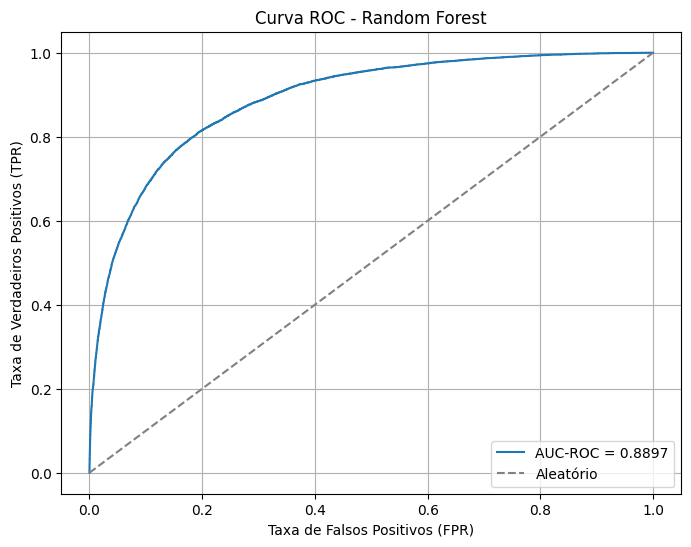

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Obter as probabilidades da classe positiva (1) no conjunto de teste
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para a classe "1" (Abandono)

# Calcular o AUC-ROC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc_score:.4f}")

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Definir variáveis independentes e alvo
X = df_modelagem[variaveis_independentes]
y = df_modelagem['ABANDONO']

# Dividir em treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identificar variáveis categóricas
categorical_cols = X.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Deixar variáveis numéricas como estão
)



In [ ]:
# Criar pipeline com pré-processamento e XGBoost
from xgboost import XGBClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        scale_pos_weight=5  # Ajustar peso para lidar com desbalanceamento
    ))
])



In [ ]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva


In [ ]:
# Avaliar o modelo
print("Relatório de Classificação XGBoost:")
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

Relatório de Classificação XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     59633
           1       0.52      0.76      0.62     10210

    accuracy                           0.86     69843
   macro avg       0.74      0.82      0.77     69843
weighted avg       0.89      0.86      0.87     69843

Acurácia: 0.8640665492604842


AUC-ROC: 0.9080


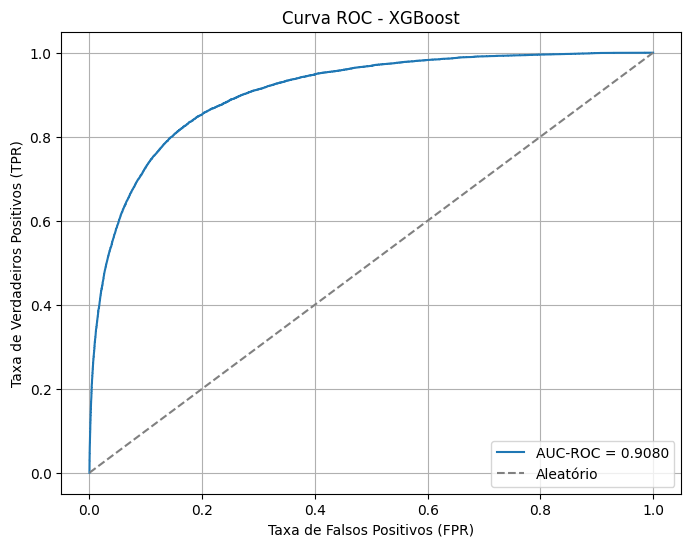

In [ ]:
# Calcular e exibir a AUC-ROC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc_score:.4f}")

# Plotar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
from lightgbm import LGBMClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        scale_pos_weight=5  # Ajustar peso para lidar com desbalanceamento
    ))
])

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Treinar e avaliar o modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 23824, number of negative: 139142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 162966, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146190 -> initscore=-1.764802
[LightGBM] [Info] Start training from score -1.764802


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print("Relatório de Classificação - LightGBM:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

Relatório de Classificação - LightGBM:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     59633
           1       0.48      0.81      0.60     10210

    accuracy                           0.84     69843
   macro avg       0.72      0.83      0.75     69843
weighted avg       0.89      0.84      0.86     69843

AUC-ROC: 0.9090


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

# Identificar índices das variáveis categóricas
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Criar e treinar o modelo
cat_model = CatBoostClassifier(
    random_state=42,
    iterations=100,
    depth=10,
    learning_rate=0.1,
    class_weights=[1, 5],  # Ajustar pesos das classes
    cat_features=categorical_indices,
    verbose=0
)

cat_model.fit(X_train, y_train)



In [ ]:
# Fazer predições
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("Relatório de Classificação - CatBoost:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

Relatório de Classificação - CatBoost:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     59633
           1       0.49      0.80      0.60     10210

    accuracy                           0.85     69843
   macro avg       0.72      0.83      0.75     69843
weighted avg       0.89      0.85      0.86     69843

AUC-ROC: 0.9079


In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

TabNetClassifier não aceita diretamente objetos do tipo Pandas DataFrame ou Series como entrada para o método fit. Em vez disso, é necessário converter os dados para arrays do NumPy.

Além disso,  o modelo TabNet espera que todas as entradas (features) sejam numéricas, mas há valores categóricos ou strings, como 'M', em seu conjunto de dados. É necessário converter as variáveis categóricas para um formato numérico antes de passar os dados ao modelo.

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Definir o modelo TabNetClassifier
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

# Identificar colunas categóricas no X_train
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Aplicar LabelEncoder em cada variável categórica
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Usar o mesmo mapeamento do treino
    label_encoders[col] = le  # Armazenar o encoder para reutilização

# Converter para NumPy após codificação
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# Treinar o modelo TabNet
clf.fit(
    X_train_np, y_train_np,  # Dados de treinamento
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],  # Conjuntos de avaliação
    eval_name=['train', 'test'],  # Nomes dos conjuntos
    eval_metric=['auc', 'balanced_accuracy'],  # Métricas de avaliação
    max_epochs=200, patience=60,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)


epoch 0  | loss: 0.54631 | train_auc: 0.73074 | train_balanced_accuracy: 0.6784  | test_auc: 0.72844 | test_balanced_accuracy: 0.67686 |  0:00:13s
epoch 1  | loss: 0.48637 | train_auc: 0.85013 | train_balanced_accuracy: 0.7703  | test_auc: 0.84741 | test_balanced_accuracy: 0.76733 |  0:00:27s
epoch 2  | loss: 0.4564  | train_auc: 0.87169 | train_balanced_accuracy: 0.79684 | test_auc: 0.86964 | test_balanced_accuracy: 0.7939  |  0:00:40s
epoch 3  | loss: 0.44544 | train_auc: 0.86706 | train_balanced_accuracy: 0.78726 | test_auc: 0.86663 | test_balanced_accuracy: 0.78481 |  0:00:56s
epoch 4  | loss: 0.44837 | train_auc: 0.87682 | train_balanced_accuracy: 0.79601 | test_auc: 0.87474 | test_balanced_accuracy: 0.79255 |  0:01:11s


In [ ]:
print(clf.history)

{'loss': [0.5458348787351879, 0.49742185375699405, 0.4847399849762509, 0.4795852854396025, 0.47516957659194287, 0.46947307313448133, 0.46636059162803495, 0.4638994026956983, 0.4467261042220734, 0.4222021844538094, 0.41112542826626414, 0.40320292036026817, 0.4001526428413336, 0.41321270196301163, 0.39754501544009985, 0.39656187832679557, 0.3992905252126828, 0.3960216727922058, 0.39401145036678203, 0.3881765686641855, 0.3914076278278243, 0.390830644288207, 0.38852437147232993, 0.38788422607391515, 0.3837677057665471, 0.38513125009288807, 0.38519795913065324, 0.382482469772047, 0.38380797285826956, 0.37904177279546836, 0.3793384989755178, 0.37725786705309283, 0.38080183715906496, 0.3804292374350657, 0.3774095319348913, 0.38132142845875033, 0.3781755473791843, 0.3763682278657439, 0.3733417332401353, 0.3740185123925536, 0.3726887498228544, 0.3711193945643028, 0.37003861039643937, 0.37132552851831285, 0.3702573211876189, 0.3693236662238482, 0.37196708452450933, 0.37042507205644054, 0.3691479

In [ ]:
# Verificar se 'valid_auc' ou outras métricas estão disponíveis
if hasattr(clf.history, 'valid_auc'):
    print("Métricas de validação (AUC):", clf.history['valid_auc'])

if hasattr(clf.history, 'valid_balanced_accuracy'):
    print("Métricas de Balanced Accuracy:", clf.history['valid_balanced_accuracy'])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Fazer predições no conjunto de teste
y_pred = clf.predict(X_test_np)
y_proba = clf.predict_proba(X_test_np)[:, 1]  # Probabilidades para a classe positiva (1)

# Calcular métricas
precision_0 = precision_score(y_test_np, y_pred, pos_label=0)
recall_0 = recall_score(y_test_np, y_pred, pos_label=0)
f1_0 = f1_score(y_test_np, y_pred, pos_label=0)

precision_1 = precision_score(y_test_np, y_pred, pos_label=1)
recall_1 = recall_score(y_test_np, y_pred, pos_label=1)
f1_1 = f1_score(y_test_np, y_pred, pos_label=1)

accuracy = accuracy_score(y_test_np, y_pred)
auc_roc = roc_auc_score(y_test_np, y_proba)

# Exibir resultados
print(f"Precision (Classe 0): {precision_0:.4f}")
print(f"Recall (Classe 0): {recall_0:.4f}")
print(f"F1-score (Classe 0): {f1_0:.4f}")
print(f"Precision (Classe 1): {precision_1:.4f}")
print(f"Recall (Classe 1): {recall_1:.4f}")
print(f"F1-score (Classe 1): {f1_1:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


KeyboardInterrupt: 

 XGBoost com validação cruzada e hiperparâmetros

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Definir o modelo
xgb = XGBClassifier(random_state=42)

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Configurar o RandomizedSearchCV
scorer = make_scorer(roc_auc_score, needs_proba=True)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinações aleatórias a testar
    scoring=scorer,
    cv=5,  # Número de folds na validação cruzada
    verbose=2,
    n_jobs=-1,  # Paralelizar busca
    random_state=42
)

# Executar a busca pelos melhores parâmetros
random_search_xgb.fit(X_train, y_train)

# Exibir os melhores parâmetros e desempenho
print(f"Melhores parâmetros (XGBoost): {random_search_xgb.best_params_}")
print(f"AUC Média: {random_search_xgb.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Melhores parâmetros (XGBoost): {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
AUC Média: 0.9116


In [ ]:
# Treinar modelo final com os melhores parâmetros
best_xgb = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=5,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    colsample_bytree=0.7,
    random_state=42
)

# Ajustar ao conjunto de treinamento completo
best_xgb.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred = best_xgb.predict(X_test)

# Calcular métricas no conjunto de teste
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print(f"AUC no conjunto de teste: {roc_auc_score(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

           0       0.96      0.86      0.91     59633
           1       0.49      0.80      0.61     10210

    accuracy                           0.85     69843
   macro avg       0.73      0.83      0.76     69843
weighted avg       0.89      0.85      0.86     69843

AUC no conjunto de teste: 0.9103


Lightgbm com validação cruzada e hiperparâmetros

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Definir o modelo LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Configuração do scorer
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Configuração do RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,  # Modelo definido acima
    param_distributions=param_grid,
    n_iter=100,  # Número de combinações a testar
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Executar o RandomizedSearchCV
random_search_lgbm.fit(X_train, y_train)

# Exibir os melhores parâmetros e o desempenho
print(f"Melhores parâmetros (LightGBM): {random_search_lgbm.best_params_}")
print(f"AUC Média: {random_search_lgbm.best_score_:.4f}")



Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 23824, number of negative: 139142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 762
[LightGBM] [Info] Number of data points in the train set: 162966, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146190 -> initscore=-1.764802
[LightGBM] [Info] Start training from score -1.764802
Melhores parâmetros (LightGBM): {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
AUC Média: 0.9124


In [ ]:
# Treinar o modelo final
best_lgbm = LGBMClassifier(
    subsample=1.0,
    scale_pos_weight=1,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    colsample_bytree=0.7,
    random_state=42
)

best_lgbm.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

# Avaliar o desempenho no conjunto de teste
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print(f"AUC no conjunto de teste: {roc_auc_score(y_test, y_proba):.4f}")


[LightGBM] [Info] Number of positive: 23824, number of negative: 139142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 762
[LightGBM] [Info] Number of data points in the train set: 162966, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146190 -> initscore=-1.764802
[LightGBM] [Info] Start training from score -1.764802
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     59633
           1       0.72      0.52      0.60     10210

    accuracy                           0.90     69843
   macro avg       0.82      0.74      0.77     69843
weighted avg       0.89      0.90      0.89     69843

AUC no conjunto de teste: 0.9108


Catboost com validação cruzada e hiperparâmetros

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Configurar o scorer atualizado
scorer = make_scorer(roc_auc_score, response_method='predict_proba')

# Definir o modelo
catboost = CatBoostClassifier(
    verbose=0,
    random_seed=42
)

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'scale_pos_weight': [1, 5, 10]
}

# Configurar o RandomizedSearchCV
random_search_cat = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_grid,
    n_iter=20,  # Testar 20 combinações (como no último código)
    scoring=scorer,
    cv=5,  # Manter 5 folds para consistência
    verbose=2,
    n_jobs=-1,  # Paralelizar busca
    random_state=42
)

# Executar a busca pelos melhores parâmetros
random_search_cat.fit(X_train, y_train)

# Exibir os melhores parâmetros e desempenho
print(f"Melhores parâmetros (CatBoost): {random_search_cat.best_params_}")
print(f"AUC Média: {random_search_cat.best_score_:.4f}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# Treinar o modelo final
best_catboost = CatBoostClassifier(
    scale_pos_weight=1,
    learning_rate=0.2,
    l2_leaf_reg=3,
    iterations=300,
    depth=6,
    verbose=0,
    random_seed=42
)

best_catboost.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)[:, 1]

# Avaliar o desempenho no conjunto de teste
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print(f"AUC no conjunto de teste: {roc_auc_score(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

           0       0.92      0.97      0.94     59633
           1       0.73      0.52      0.61     10210

    accuracy                           0.90     69843
   macro avg       0.82      0.74      0.78     69843
weighted avg       0.89      0.90      0.89     69843

AUC no conjunto de teste: 0.9116


In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
# Criar o explicador para o modelo LightGBM
explainer = shap.TreeExplainer(best_lgbm)

In [ ]:
# Calcular valores SHAP
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


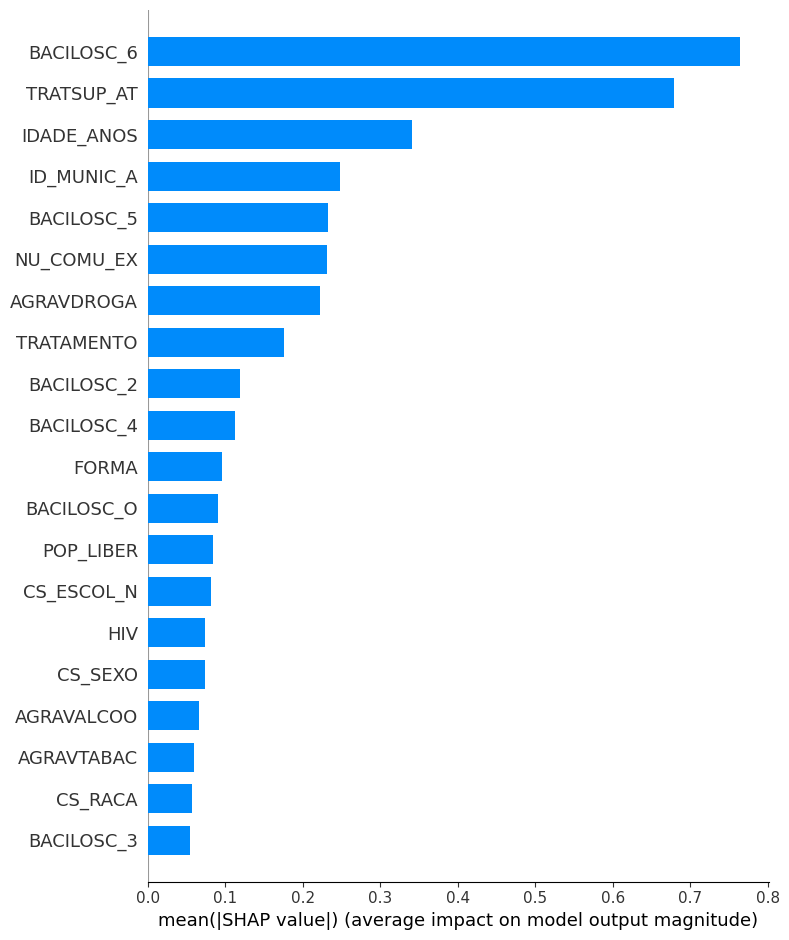

In [ ]:
# Visualizar o impacto global das variáveis
shap.summary_plot(shap_values, X_test, plot_type="bar")

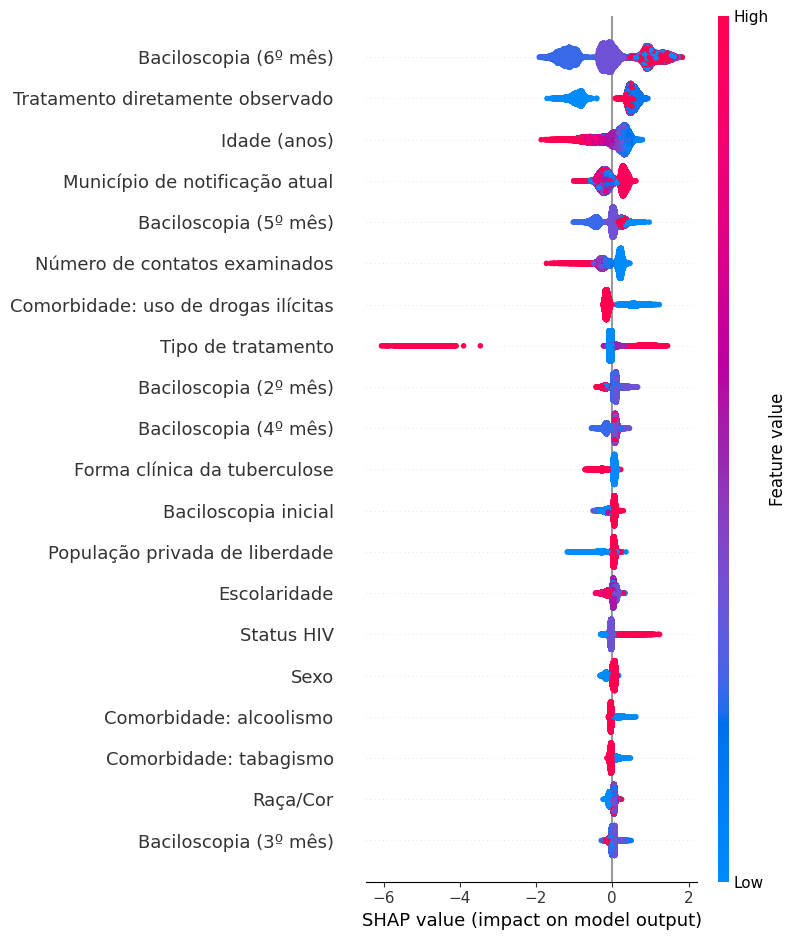

In [ ]:
# Dicionário para traduzir os nomes das variáveis no gráfico SHAP
variable_mapping = {
    "BACILOSC_6": "Baciloscopia (6º mês)",
    "TRATSUP_AT": "Tratamento diretamente observado",
    "IDADE_ANOS": "Idade (anos)",
    "ID_MUNIC_A": "Município de notificação atual",
    "BACILOSC_5": "Baciloscopia (5º mês)",
    "NU_COMU_EX": "Número de contatos examinados",
    "AGRAVDROGA": "Comorbidade: uso de drogas ilícitas",
    "TRATAMENTO": "Tipo de tratamento",
    "BACILOSC_2": "Baciloscopia (2º mês)",
    "BACILOSC_4": "Baciloscopia (4º mês)",
    "FORMA": "Forma clínica da tuberculose",
    "BACILOSC_O": "Baciloscopia inicial",
    "POP_LIBER": "População privada de liberdade",
    "CS_ESCOL_N": "Escolaridade",
    "HIV": "Status HIV",
    "CS_SEXO": "Sexo",
    "AGRAVALCOO": "Comorbidade: alcoolismo",
    "AGRAVTABAC": "Comorbidade: tabagismo",
    "CS_RACA": "Raça/Cor",
    "BACILOSC_3": "Baciloscopia (3º mês)"
}

# Ajustando os nomes no gráfico SHAP
shap.summary_plot(shap_values, X_test, feature_names=[variable_mapping.get(col, col) for col in X_test.columns])


Dúvida: O modelo é muito dependente da variável Baciloscopia no 6° mês??

In [ ]:
print(X_train_reduced.head())
print(X_train_reduced.columns)

        IDADE_ANOS  CS_SEXO  CS_GESTANT  CS_RACA  CS_ESCOL_N  ID_OCUPA_N  \
693930        34.0        1         9.0      1.0         5.0         9.0   
429154        42.0        0         5.0      1.0         5.0         0.0   
168099        28.0        1         6.0      1.0         3.0         9.0   
430924        74.0        1         0.0      3.0         9.0         0.0   
527072        17.0        0         5.0      4.0         7.0         9.0   

        TRATAMENTO  RAIOX_TORA  TESTE_TUBE  FORMA  ...  POP_SAUDE  POP_IMIG  \
693930           3         1.0         9.0    1.0  ...        3.0       2.0   
429154           3         1.0         0.0    1.0  ...        2.0       2.0   
168099           3         4.0         0.0    1.0  ...        2.0       2.0   
430924           1         4.0         0.0    1.0  ...        2.0       2.0   
527072           1         4.0         9.0    1.0  ...        2.0       1.0   

        BENEF_GOV  AGRAVDROGA  AGRAVTABAC  TEST_MOLEC  TEST_SENSI  A

In [ ]:
# Garantir que X_train_reduced e X_test_reduced são DataFrames com colunas válidas
X_train_reduced = pd.DataFrame(X_train.drop(columns=['BACILOSC_6']), columns=X_train.drop(columns=['BACILOSC_6']).columns)
X_test_reduced = pd.DataFrame(X_test.drop(columns=['BACILOSC_6']), columns=X_test.drop(columns=['BACILOSC_6']).columns)

# Resetar o índice
X_train_reduced = X_train_reduced.reset_index(drop=True)
X_test_reduced = X_test_reduced.reset_index(drop=True)

# Definir e treinar o modelo CatBoost
best_catboost = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,
    random_seed=42,
    verbose=0  # Silenciar logs
)

# Treinar o modelo
best_catboost.fit(X_train_reduced, y_train)



In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Remover a variável BACILOSC_6 dos conjuntos de treinamento e teste
X_train_reduced = X_train.drop(columns=['BACILOSC_6'])
X_test_reduced = X_test.drop(columns=['BACILOSC_6'])

# Definir o modelo CatBoost com os melhores parâmetros encontrados
best_catboost = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,
    random_seed=42,
    verbose=0
)

# Treinar o modelo
best_catboost.fit(X_train_reduced, y_train)

# Fazer predições no conjunto de teste
y_pred_reduced = best_catboost.predict(X_test_reduced)
y_proba_reduced = best_catboost.predict_proba(X_test_reduced)[:, 1]

# Calcular as métricas de avaliação
print("Relatório de Classificação (sem BACILOSC_6):")
print(classification_report(y_test, y_pred_reduced))

# Calcular a AUC-ROC
auc_reduced = roc_auc_score(y_test, y_proba_reduced)
print(f"AUC no conjunto de teste (sem BACILOSC_6): {auc_reduced:.4f}")

Relatório de Classificação (sem BACILOSC_6):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     59633
           1       0.72      0.43      0.54     10210

    accuracy                           0.89     69843
   macro avg       0.81      0.70      0.74     69843
weighted avg       0.88      0.89      0.88     69843

AUC no conjunto de teste (sem BACILOSC_6): 0.8871


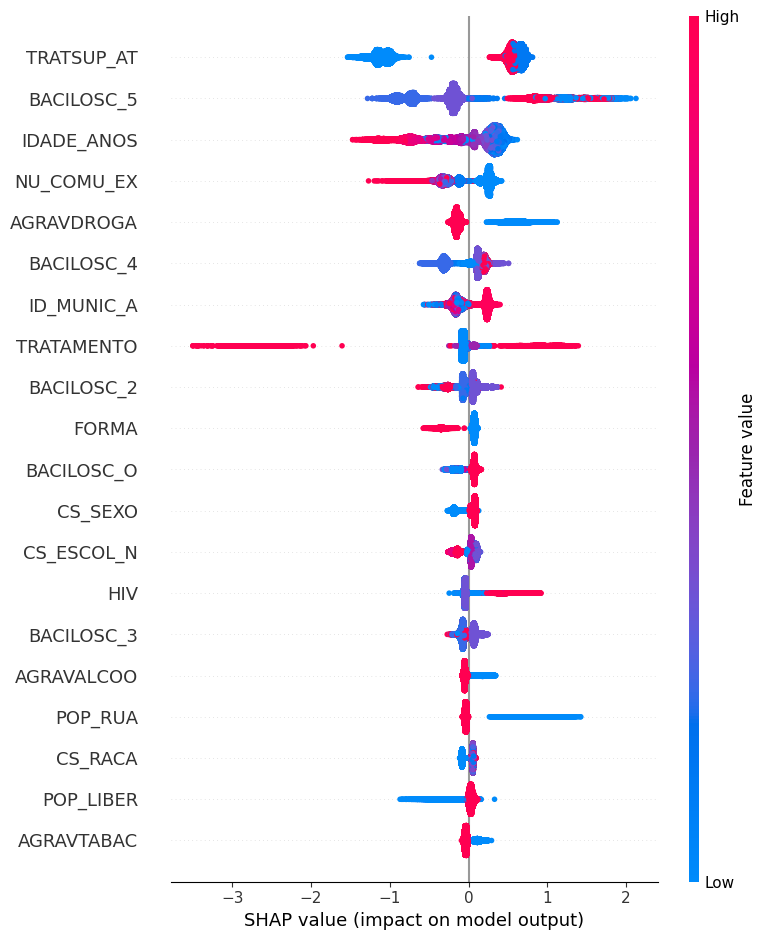

In [ ]:
# Calcular valores SHAP usando o TreeExplainer
explainer = shap.TreeExplainer(best_catboost)
shap_values_reduced = explainer.shap_values(X_test_reduced)

# Plotar o SHAP Summary Plot
shap.summary_plot(shap_values_reduced, X_test_reduced)